# Case 3 - Param Searching

The goal is to test different model features and locate proper hyperparameters.

In [2]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import pandas as pd

import os
assert os.path.exists("Acutal Testing Data.csv")

# can't use sklearn rip, gotta self implement
def pca(vec, comp=-1):
    """Perform PCA, output components + explained variance %"""
    c_vec = vec - np.mean(vec, axis=0)
    cov = np.cov(c_vec) / vec.shape[0]
    v, w = np.linalg.eig(cov)
    idx = v.argsort()[::-1] # Sort descending and get sorted indices
    v = v[idx]
    w = w[:,idx]
    return w[:, :comp], np.sum(np.square(v[:comp]))/np.sum(np.square(v))

### Function List

Functions will need to pass a parameter dict of the above form.

In [108]:
# Obtain returns and forecasted returns from I/O
def obtainReturns():
    """
    Return array structures, all_rets, and all_pred_rets
    """
    atdf = pd.read_csv("Acutal Testing Data.csv")
    ptdf1 = pd.read_csv("Predicted Testing Data Analyst 1.csv")
    ptdf2 = pd.read_csv("Predicted Testing Data Analyst 1.csv")
    ptdf3 = pd.read_csv("Predicted Testing Data Analyst 1.csv")
    idx = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
    price = np.array([list(atdf[idx[i]]) for i in range(len(idx))])
    price1 = np.array([list(ptdf1[idx[i]]) for i in range(len(idx))])
    price2 = np.array([list(ptdf2[idx[i]]) for i in range(len(idx))])
    price3 = np.array([list(ptdf3[idx[i]]) for i in range(len(idx))])
    n = atdf.shape[0]
    all_rets = (price[:, 1:] - price[:, :-1]) / price[:, :-1]
    # Add interpolation (linear) right here
    all_pred_rets1 = (price1[:, 1:] - price1[:, :-1]) / price1[:, :-1]
    all_pred_rets2 = (price2[:, 1:] - price2[:, :-1]) / price2[:, :-1]
    all_pred_rets3 = (price3[:, 1:] - price3[:, :-1]) / price3[:, :-1]
    return all_rets, all_pred_rets1, all_pred_rets2, all_pred_rets3

# Generate alphas from features and hyperparameters
# Considered methods include EMA on a lookback period
def getAlphas(rets, pred_rets, EMA_eps=0.01, alpha_w=[0.5, 0.5], mom_rev=1, **params):
    """
    Returns an array of alphas, same size as input rets.
    pred_rets should be a singular array of size # assets.
    Also returns cov of initial alphas = pred. returns
    """
    n = rets.shape[1]
    per_weights = np.power(1.000 - EMA_eps, np.arange(n)[::-1])
    EMA_rets = rets * np.expand_dims(per_weights, 0)
    # perform EMA on given rets
    self_alphas = EMA_rets.sum(axis=1)
    weighted_alphas = self_alphas*alpha_w[0] + pred_rets*alpha_w[1]
    return weighted_alphas*mom_rev, np.cov(rets)
    
# Generate market betas using PCA on alphas
# We use these to try to control the market neutrality of the opt
def getBetas(rets, pca_count=1, **params):
    """
    Returns an array of betas with size = # assets in universe
    """
    # standardize returns
    stan_rets = rets - np.mean(rets, axis=1, keepdims=True)
    stan_rets = stan_rets / np.std(stan_rets, axis=1, keepdims=True)
    betas, expl_var = pca(stan_rets, pca_count)
    betas = betas / np.sum(np.abs(betas))
    return betas

# Define utility function to optimize for weights
def util_func(w, alphas, cov, var_penalty, subtr=True, **params):
    ER = np.sum(w*alphas)
    var_factor = w.T @ cov @ w
    
    # change this to / to test other expression
    if subtr:
        return ER - (var_penalty*var_factor)
    else:
        return ER / var_factor

# Solve optimization problem from features and hyperparameters
def solveWeights(rets, pred_rets, var_penalty=1, var_cap=0.001, **params):
    """
    Returns an array of weights with size = # assets in universe.
    Also returns expected variance
    """
    m = rets.shape[0]
    alphas, cov_mat = getAlphas(rets, pred_rets, **params)
    betas = getBetas(rets, **params)
    
    # define optimization problem using scipy
    func = lambda x: util_func(x, alphas, cov_mat, var_penalty, **params) # utility
    init_x = [0.5/m for i in range(m)]
    bnds = ((0, 1),) * m # nonnegative elementwise bounds on weights
    portfolio_var = lambda x: x.T @ cov_mat @ x # portfolio variance
    cum_weights = lambda x: np.sum(np.abs(x))
    cum_betas = lambda x: np.sum(x*betas)
    cons = (
        NonlinearConstraint(cum_betas, 0, 0), # market neutrality
        NonlinearConstraint(cum_weights, 0, 1, keep_feasible=True), # weight allocation
        NonlinearConstraint(portfolio_var, 0, var_cap), # hard variance cap
    )
    res = minimize(func, init_x, bounds=bnds, constraints=cons)
    
    weights = res.x
    return weights, weights.T @ cov_mat @ weights

# Overall timestepping process (for backtesting?)
def execute(max_time, all_rets, all_pred_rets, lookback=3, vol_look=21, vol_power=1, **params):
    """
    Returns a dataframe containing daily portfolio returns and
    overall Sharpe
    """
    periods = min(max_time, all_rets.shape[1])
    net_value = 1.0
    backtest_res = []
    
    # period - 1 since we do not make decision on last day 
    # nothing to compare forecast to
    for i in tqdm(range(lookback, periods - 1)):
        # obtain lookback data and current day
        rets = all_rets[:, i - lookback:i]
        pred_rets = all_pred_rets[:, i]
        next_rets = all_rets[:, i]
        
        act_look = min(i, vol_look)
        vol_rets = all_rets[:, i - act_look:i]
        vol = np.std(vol_rets, axis=1)
        inv_vol = 1 / vol ** vol_power
        inv_vol = inv_vol / np.sum(inv_vol) * all_rets.shape[0]
        
        params['mom_rev'] = inv_vol
        
        # solve
        weights, exp_var = solveWeights(rets, pred_rets, **params)
        # assert np.sum(weights) <= 1
        weights /= max(np.sum(np.abs(weights)), 1)
        port_rets = np.sum(next_rets * weights * net_value)
        frac_return = port_rets / net_value
        net_value += port_rets
        backtest_res.append({
            'period_ind': i,
            'ret': port_rets,
            'curr_portfolio': weights,
            'exposure': np.sum(weights),
            'net_value': net_value,
            'expected_variance': exp_var,
            'frac_return': frac_return,
        })
    brdf = pd.DataFrame(backtest_res)
    sharpe = np.mean(brdf.frac_return) / np.std(brdf.frac_return)
    return brdf, sharpe

### Model Testing

We should try to test our functions as well as compare alphas and predictions to the professional forecasts as well as their general accuracies.

In [103]:
all_rets, all_pred_rets1, all_pred_rets2, all_pred_rets3 = obtainReturns()

# Select parameters

test_params = {
    'lookback': 2, 
    'EMA_eps': 0.01, 
    'alpha_w': [1, 0], 
    'pca_count': 1, 
    'var_penalty': 0.25, 
    'var_cap': 0.01, 
    'subtr': True,
    'vol_look' : 21,
    'vol_pow' : 1.5,
}

In [104]:
brdf, sharpe = execute(252*10, all_rets, all_pred_rets1, **test_params)
print((252 ** 0.5)*sharpe) # annualize

  0%|▏                                         | 8/2505 [00:00<01:07, 37.02it/s]/var/folders/9t/n10tslw57h93x72dt0gjxt7h0000gn/T/ipykernel_43395/2876221840.py:21: RuntimeWarning: invalid value encountered in double_scalars
  return w[:, :comp], np.sum(np.square(v[:comp]))/np.sum(np.square(v))
100%|███████████████████████████████████████| 2505/2505 [00:54<00:00, 46.35it/s]

1.6516935649750406


Text(0.5, 0, 'days')

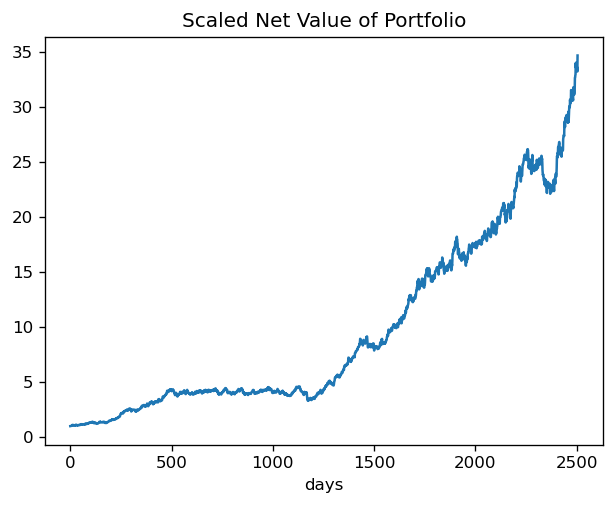

In [105]:
plt.figure(figsize=(6, 4.5), dpi=120)
plt.plot(brdf.net_value)
plt.title('Scaled Net Value of Portfolio')
plt.xlabel('days')

### OLS Test (assumptions present)
We will need to do multivariate OLS per asset (so out of 9). Question: what training set should we use?

In [10]:
# get coeffs
ols_pred_coeffs = []
n_rets = all_rets.shape[1]
max_day = 31
train_idx = range(0, max_day)
n_train = len(train_idx)

all_pred_rets = np.zeros((all_rets.shape[0], n_rets))

for asset in range(all_rets.shape[0]):
    A = np.zeros((n_train, 3))
    A[:, 0] = all_pred_rets1[asset, train_idx].T
    A[:, 1] = all_pred_rets2[asset, train_idx].T
    A[:, 2] = all_pred_rets3[asset, train_idx].T
    b = all_rets[asset, train_idx].T
    coeffs = np.linalg.lstsq(A, b, rcond=None)[0]
    ols_pred_coeffs.append(coeffs)
    Aa = np.zeros((n_rets, 3))
    Aa[:, 0] = all_pred_rets1[asset, :].T
    Aa[:, 1] = all_pred_rets2[asset, :].T
    Aa[:, 2] = all_pred_rets3[asset, :].T
    new_b = Aa @ coeffs
    all_pred_rets[asset, :] = new_b.T
ols_pred_coeffs = np.array(ols_pred_coeffs)
print(ols_pred_coeffs)
print(np.linalg.norm((all_pred_rets - all_rets)/all_rets))

[[ 0.01581311  0.01581311  0.01581311]
 [-0.01234799 -0.01234799 -0.01234799]
 [ 0.00143602  0.00143602  0.00143602]
 [ 0.05683122  0.05683122  0.05683122]
 [-0.00510266 -0.00510266 -0.00510266]
 [ 0.05398255  0.05398255  0.05398255]
 [-0.00692854 -0.00692854 -0.00692854]
 [ 0.01030878  0.01030878  0.01030878]
 [-0.03103998 -0.03103998 -0.03103998]]
1329.3522653137884


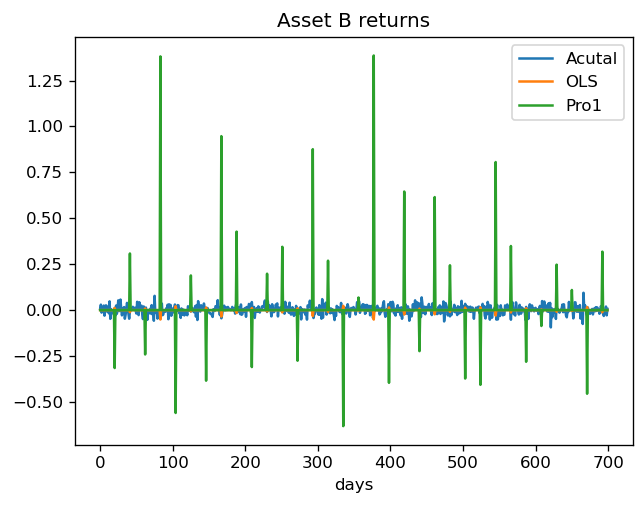

In [176]:
plt.figure(figsize=(6, 4.5), dpi=120)
plt.plot(all_rets[1, :700])
plt.plot(all_pred_rets[1, :700])
plt.plot(all_pred_rets1[1, :700])
plt.title('Asset B returns')
plt.xlabel('days')
#plt.ylim([-0.01, 0.01])
plt.legend(['Acutal', 'OLS', 'Pro1'])

Findings: Turns out, the professional predictions are made every 21 days and thus have 0 returns then. So, we should (linearly) interpolate all_pred_rets(x) between the 21 day periods, though even then, this seems fairly sus.

### Param Search Framework

In [7]:
# functions to convert between testing integers and param dictionaries
def toGridDict(testNum, gridSpecs, gridOrder):
    """
    Converts a param search testing number to the corresponding param dictionary.
    """
    paramDict = {}
    for key in gridOrder:
        n = len(gridSpecs[key])
        rem = testNum % n
        paramDict[key] = gridSpecs[key][int(rem)]
        testNum = (testNum - rem) / n
    return paramDict

def toTestNum(paramDict, gridSpecs, gridOrder):
    """
    Converts a param dictionary to the corresponding param testing number.
    """
    testNum = 0
    currBase = 1
    for key in gridOrder:
        testNum = testNum + currBase * gridSpecs[key].index(paramDict[key])
        n = len(gridSpecs[key])
        currBase = currBase * n
    return testNum

def maxTestNum(gridSpecs, gridOrder):
    """Returns |Theta| for param space Theta."""
    maxTests = 1
    for key in gridOrder:
        maxTests = maxTests * len(gridSpecs[key])
    return maxTests

In [12]:
# functions to I/O param testing results from df to .csv
# dataframe format for results should be test_idx, sharpe, 
# storing -1 as init. sharpe
def initParamResultsDataframe(gridSpecs, gridOrder):
    """
    Instantiates the dataframe to store results of param searching.
    """
    maxTests = maxTestNum(gridSpecs, gridOrder)
    initSharpe = [-1] * maxTests
    initNetValue = [-1] * maxTests
    initTestNum = range(maxTests)
    paramDataDict = {
        'test_idx' : initTestNum,
        'sharpe' : initSharpe,
    }
    prdf = pd.DataFrame(paramDataDict, index=initTestNum)
    return prdf

def storeCurrentParamResults(paramfile_name, df):
    """
    Stores current dataset in DataFrame to datafile_name.csv.
    """
    file_str = paramfile_name + '.csv'
    df.to_csv(file_str, index=False)
    return ('Finished writing to ' + file_str)

def readCurrentParamResults(paramfile_name, gridSpecs, gridOrder):
    """
    Checks and reads paramfile_name.csv for a DataFrame of grid data and progress.
    """
    file_str = paramfile_name + '.csv'
    file_exists = os.path.exists(file_str)
    assert file_exists, 'file does not exist!'
    # if exists:
    prdf = pd.read_csv(file_str)
    maxTests = prdf.shape[0]
    untested_indices = []
    for i in range(maxTests):
        if prdf.sharpe[i] == -1:
            untested_indices.append(prdf.test_idx[i])
    return prdf, untested_indices

In [13]:
# perform backtesting on each passed in parameter set, then write
def paramEvaluate(prdf, testIndList, search_rets, search_pred_rets, gridSpecs, gridOrder):
    """
    Evaluate Sharpe Ratios of testing numbers in testNumList against file data.
    """
    idx_lst = list(prdf['test_idx'])
    for i in testIndList:
        paramDict = toGridDict(i, gridSpecs, gridOrder)
        max_time = search_rets.shape[1]
        backtest_results, sharpe = execute(max_time, search_rets, search_pred_rets, **paramDict)
        idx = idx_lst.index(i)
        prdf['sharpe'].iat[idx] = sharpe * (252 ** 0.5)
    return prdf

In [113]:
# Setup
pr_filename = 'full_psearch_0to1yr_2'
test_period_idx = range(0, 252) # first 3 years
search_rets = all_rets[:, test_period_idx]
search_pred_rets = all_pred_rets[:, test_period_idx]

param_order = [
    'lookback', 'EMA_eps', 'alpha_w', 'pca_count', 
    'var_penalty', 'var_cap', 'subtr', 'vol_look', 'vol_power',
]
param_specs = {
    "lookback" : [2, 4],
    "EMA_eps" : [0.01],
    "alpha_w" : [[1, 0]], # weights for self preds and "pro" preds
    "pca_count" : [1],
    "var_penalty" : [0.25, 2],
    "var_cap" : [0.01],
    "subtr" : [True],
    "vol_look" : [21],
    "vol_power" : [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]
}

prdf = initParamResultsDataframe(param_specs, param_order)
storeCurrentParamResults(pr_filename, prdf)

'Finished writing to full_psearch_0to1yr_2.csv'

### Run Param Search Here:

In [114]:
prdf, untested_indices = readCurrentParamResults(pr_filename, param_specs, param_order)
print(len(untested_indices))

for i in range(8):
    print(i)
    prdf, untested_indices = readCurrentParamResults(pr_filename, param_specs, param_order)
    prdf = paramEvaluate(prdf, untested_indices[:4], search_rets, search_pred_rets, param_specs, param_order)
    storeCurrentParamResults(pr_filename, prdf)
    
print('Done.')

32
0


  4%|█▊                                        | 11/249 [00:00<00:05, 40.30it/s]/var/folders/9t/n10tslw57h93x72dt0gjxt7h0000gn/T/ipykernel_43395/2876221840.py:21: RuntimeWarning: invalid value encountered in double_scalars
  return w[:, :comp], np.sum(np.square(v[:comp]))/np.sum(np.square(v))
100%|█████████████████████████████████████████| 247/247 [00:04<00:00, 57.33it/s]


1


100%|█████████████████████████████████████████| 247/247 [00:04<00:00, 56.26it/s]


2


100%|█████████████████████████████████████████| 247/247 [00:04<00:00, 52.95it/s]


3


100%|█████████████████████████████████████████| 247/247 [00:04<00:00, 57.39it/s]


4


100%|█████████████████████████████████████████| 247/247 [00:04<00:00, 52.00it/s]


5


100%|█████████████████████████████████████████| 247/247 [00:04<00:00, 52.59it/s]


6


100%|█████████████████████████████████████████| 247/247 [00:04<00:00, 52.78it/s]


7


100%|█████████████████████████████████████████| 247/247 [00:04<00:00, 51.12it/s]

Done.


In [106]:
print(toGridDict(1, param_specs, param_order))

{'lookback': 3, 'EMA_eps': 0.01, 'alpha_w': [1, 0], 'pca_count': 1, 'var_penalty': 0.25, 'var_cap': 0.01, 'subtr': True, 'vol_look': 21}


TODO:

-check mean reversion, this could be a big solution
-implement interpolation

### Momentum vs. Reversion

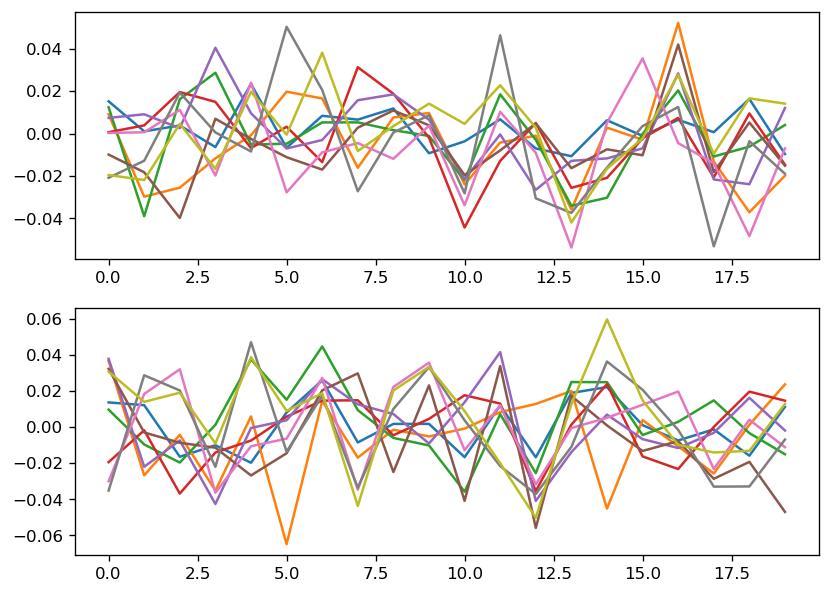

In [36]:
plt.figure(figsize=(8, 6), dpi=120)
plt.subplot(2, 1, 1)
for i in range(9):
    plt.plot(all_rets[i, -20-252:-252])
plt.subplot(2, 1, 2)
for i in range(9):
    plt.plot(all_rets[i, 252*7:252*7+20])

In [63]:
print(np.std(all_rets[:, -252*3:], axis=1).argsort())
print(np.std(all_rets[:, :252], axis=1).argsort())
print(np.std(all_rets[:, 252*6:252*7], axis=1).argsort())
print(np.std(all_rets[:, :], axis=1).argsort())

[0 2 3 5 4 8 7 1 6]
[0 2 1 6 7 8 3 5 4]
[0 2 3 8 1 6 7 4 5]
[0 2 8 1 7 6 3 5 4]


Indeed, we see that asset A (blue) = 0 is consistently more stable and good for momentum detection.

In [101]:
vol = np.std(all_rets[:, -21:], axis=1)
inv_vol = 1 / (vol ** 1.5)
inv_vol = inv_vol / np.sum(inv_vol) * all_rets.shape[0]
print(inv_vol)

[2.11645461 0.67832864 1.24478195 1.23745923 0.92120237 0.81262499
 0.68516886 0.68518865 0.61879071]
